In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, concatenate, Input
from tensorflow.keras.models import Sequential, load_model, Model
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
# from keras.utils import to_categorical
from sklearn import metrics
import h5py
from sklearn import utils
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import categorical_crossentropy as cce
import pandas as pd
import seaborn as sns

## Load Validation Data

In [2]:
X_val_shuff = np.load('Te_X_val_shuff_20200820.npy')
Y_val_shuff = np.load('Te_Y_val_shuff_20200820.npy')

## No wrong labels

In [11]:
def down(filters, input_):
    down_ = Conv2D(filters, (3, 3))(input_)
    down_res = Activation('relu')(down_)
    down_pool = MaxPooling2D((2, 2))(down_)
    return down_pool

def final_stack(input1_):
    flat = Flatten()(input1_)
    dense1 = Dense(64*2)(flat)
    act1 = Activation('relu')(dense1)
    drop = Dropout(0.5)(act1)
    dense2 = Dense(2)(drop)
    act2 = Activation('softmax')(dense2)
    return act2


def first_cnn(input_):
    down1 = down(32*2,input_)
    down2 = down(32*2,down1)
    down3 = down(64*2,down2)
    down4 = down(64*2,down3)
    down5 = down(64*2,down4)
    # final = first_final_stack(down5)
    return down5

def complete_model(input_shape):
    input1 = Input(shape=input_shape)
    final1 = first_cnn(input1)
    final = final_stack(final1)
    model = Model(inputs=input1, outputs=final)
    return model

model = complete_model((128, 128,1))
model.compile(loss='categorical_crossentropy',
              optimizer='Adadelta',
              metrics=['accuracy'])

In [12]:
model.load_weights('savio_nets/rcnnV1_counternet_00pwrongleftrightlabels_weights_20200901.h5')

In [13]:
model.evaluate(X_val_shuff,Y_val_shuff)

7/7 [==============================] - 1s 83ms/step - loss: 0.4205 - accuracy: 0.9691


[0.42053207755088806, 0.969072163105011]

In [14]:
pred = model.predict(X_val_shuff)

In [16]:
precision, recall, thresholds = metrics.precision_recall_curve(Y_val_shuff.flatten(), pred.flatten())

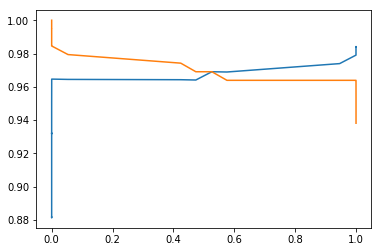

In [17]:
plt.plot(thresholds,precision[:-1])
plt.plot(thresholds,recall[:-1])

In [18]:
cfm = metrics.confusion_matrix(Y_val_shuff.flatten(),pred.flatten()>0.5,labels = [0,1])

In [20]:
cfm = cfm.astype('float') / cfm.sum(axis=0)[:, np.newaxis]

In [21]:
def plot_confusion_matrix(cfm, Y_labels,colormap, annotate = True, save=False):
    """Creates a confusion matrix for the different classes given a true labels,predictions, the dataset
    and the desired trained classfier"""
#     cfm = metrics.confusion_matrix(Y, Y_pred)
    cfm = cfm.astype('float') / cfm.sum(axis=1)[:, np.newaxis]


    plt.subplots(figsize=(5,5))
    plt.rcParams['font.size'] = 16
    if annotate == True:
        df_cfm = pd.DataFrame(data = cfm, columns=Y_labels, index=Y_labels)
        ax = sns.heatmap(df_cfm, annot=True,cmap=colormap,vmin=0,vmax=1,annot_kws={"size": 16},fmt=".2f")
        ax.collections[0].colorbar.set_yticklabels = []
        ax.set_ylabel('True label', fontsize = 16)
        ax.set_xlabel('Predicted label',fontsize = 16)
        plt.yticks(np.arange(2)+0.5,Y_labels, rotation=90, fontsize="14", va="center")
        plt.xticks(np.arange(2)+0.5,Y_labels,fontsize="14", va="center")
        plt.xticks(fontsize=14)
    else:
        ax = sns.heatmap(cfm, annot=False,cmap=colormap,vmin=0,vmax=1,xticklabels = False, yticklabels = False)
#     
    
    if save == True:
        fname = input('Specify filename to save figure to: ')
        fig = ax.get_figure()
        fig.savefig(fname)

In [19]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [22]:
new_inferno = cm.get_cmap('inferno', 512)
new_inferno = ListedColormap(new_inferno(np.linspace(0.1, 0.95, 256)))

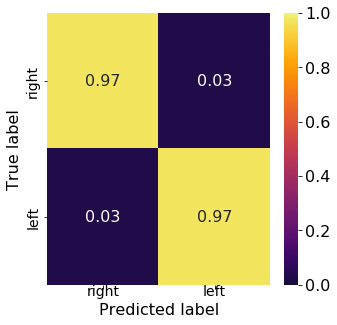

In [25]:
plot_confusion_matrix(cfm,['right','left'],new_inferno)

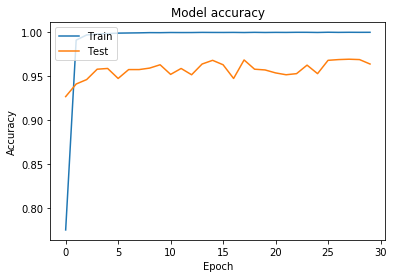

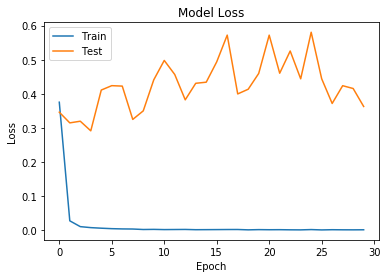

In [3]:
history = h5py.File('savio_nets/chirality_classification_00pwrongleftrightlabels_history_20200821.h5','r')

list(history.keys())

plt.plot(history['acc'][:])
plt.plot(history['val_acc'][:])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [108]:
modelE = keras.models.Sequential()
modelE.add(Conv2D(32, (3, 3), input_shape=(128, 128,1)))
modelE.add(Activation('relu'))
modelE.add(MaxPooling2D(pool_size=(2, 2)))

modelE.add(Conv2D(32, (3, 3)))
modelE.add(Activation('relu'))
modelE.add(MaxPooling2D(pool_size=(2, 2)))

modelE.add(Conv2D(64, (3, 3)))
modelE.add(Activation('relu'))
modelE.add(MaxPooling2D(pool_size=(2, 2)))

modelE.add(Conv2D(64, (3, 3)))
modelE.add(Activation('relu'))
modelE.add(MaxPooling2D(pool_size=(2, 2)))

modelE.add(Conv2D(64, (3, 3)))
modelE.add(Activation('relu'))
modelE.add(MaxPooling2D(pool_size=(2, 2)))

modelE.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
modelE.add(Dense(64))
modelE.add(Activation('relu'))
modelE.add(Dropout(0.5))
modelE.add(Dense(2))
modelE.add(Activation('softmax'))

modelE.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [109]:
modelE.load_weights('savio_nets/chirality_classification_00pwrongleftrightlabels_weights_20200821.h5')

In [7]:
modelE.evaluate(X_val_shuff,Y_val_shuff)

7/7 [==============================] - 0s 34ms/step - loss: 0.7770 - accuracy: 0.9381


[0.7769570350646973, 0.938144326210022]

In [111]:
pred = modelE.predict(X_val_shuff)

In [113]:
bin_pred = pred>0.5

In [115]:
bin_pred = bin_pred.astype('int')

In [144]:
pred.shape

(194, 2)

In [143]:
Y_val_shuff.shape

(194, 2)

In [117]:
metrics.accuracy_score(Y_val_shuff,bin_pred)

0.9381443298969072

In [138]:
loss = cce(reduction='none')

In [145]:
l1 = loss.call(Y_val_shuff,pred)

In [148]:
np.argsort(l1)[-12:]

array([114, 154, 132, 106,  60,  97, 190,  54,  45,   8, 163,  12])

In [132]:
print(bin_pred[106],Y_val_shuff[106])

[0 1] [1 0]


(-0.5, 127.5, 127.5, -0.5)

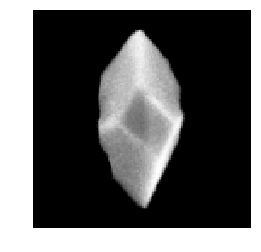

In [76]:
plt.imshow(np.fliplr(X_val_shuff[2,:,:,0]),cmap='gray')
plt.axis('off')

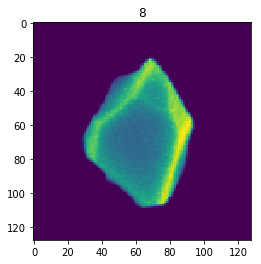

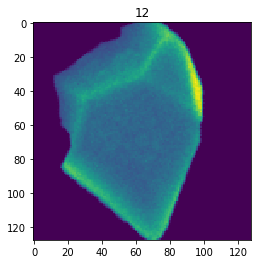

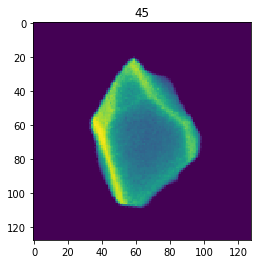

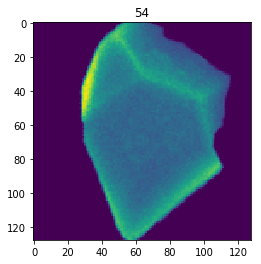

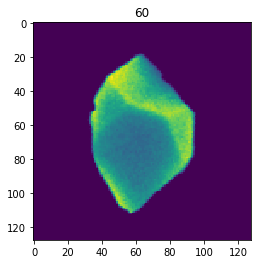

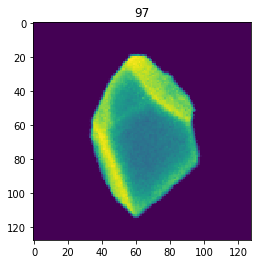

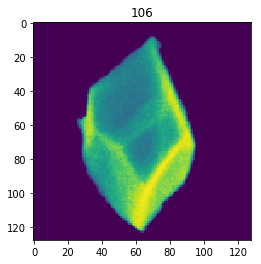

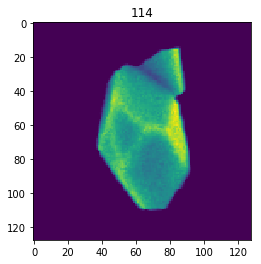

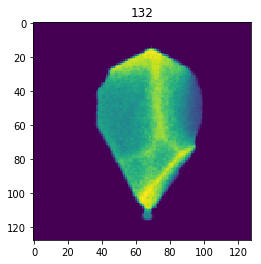

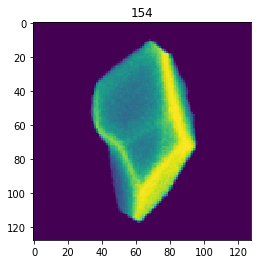

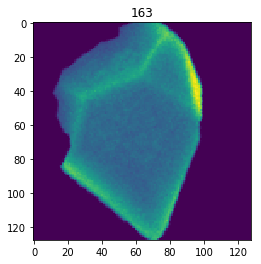

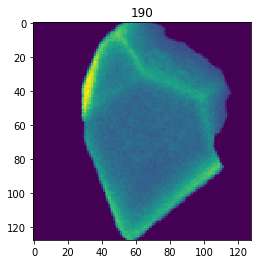

In [128]:
for idx,i in enumerate(bin_pred):
    if np.all(i == Y_val_shuff[idx]) != True:
        plt.figure()
        plt.imshow(X_val_shuff[idx,:,:,0])
        plt.title(idx)

## 5% wrong labels

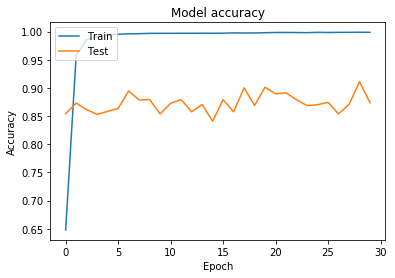

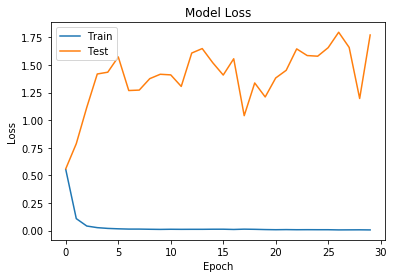

In [8]:
history = h5py.File('savio_nets/chirality_classification_05pwrongleftrightlabels_history_20200821.h5','r')

list(history.keys())

plt.plot(history['acc'][:])
plt.plot(history['val_acc'][:])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [9]:
modelE.load_weights('savio_nets/chirality_classification_05pwrongleftrightlabels_weights_20200821.h5')

In [10]:
modelE.evaluate(X_val_shuff,Y_val_shuff)

7/7 [==============================] - 0s 35ms/step - loss: 0.9083 - accuracy: 0.9330


[0.9082961678504944, 0.9329897165298462]

## 10% Wrong Labels

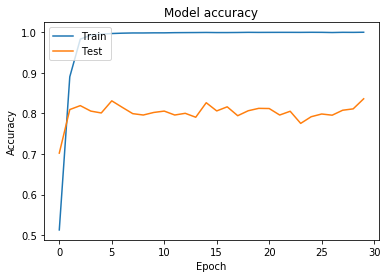

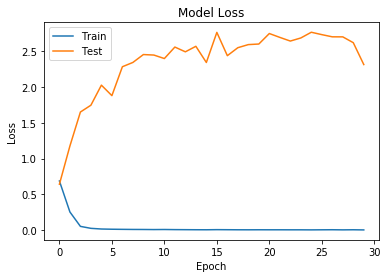

In [12]:
history = h5py.File('savio_nets/chirality_classification_10pwrongleftrightlabels_history_20200821.h5','r')

list(history.keys())

plt.plot(history['acc'][:])
plt.plot(history['val_acc'][:])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [13]:
modelE.load_weights('savio_nets/chirality_classification_10pwrongleftrightlabels_weights_20200821.h5')

In [14]:
modelE.evaluate(X_val_shuff,Y_val_shuff)

7/7 [==============================] - 0s 35ms/step - loss: 1.2254 - accuracy: 0.9124


[1.225423812866211, 0.9123711585998535]

## 20% wrong labels increased samples per epoch

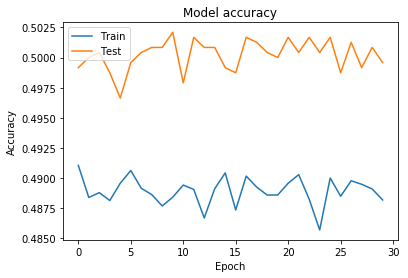

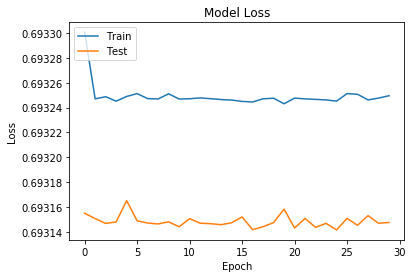

In [15]:
history = h5py.File('savio_nets/chirality_classification_20pwrongleftrightlabels_history_20200821_v3.h5','r')

list(history.keys())

plt.plot(history['acc'][:])
plt.plot(history['val_acc'][:])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [16]:
modelE.load_weights('savio_nets/chirality_classification_20pwrongleftrightlabels_weights_20200821_v3.h5')

In [17]:
modelE.evaluate(X_val_shuff,Y_val_shuff)

7/7 [==============================] - 0s 33ms/step - loss: 0.6931 - accuracy: 0.5000


[0.6931473016738892, 0.5]

In [87]:
Y_val_shuff[5]

array([1, 0])

(-0.5, 127.5, 127.5, -0.5)

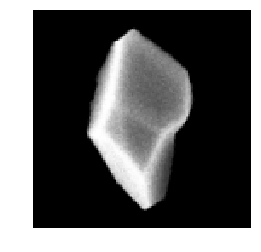

In [89]:
plt.imshow(X_val_shuff[7,:,:,0],cmap='gray')
plt.axis('off')

# Testing confidence response to flipped labels

In [7]:
right_images = np.load('20200514_right__Chiral_D_Large_TIFF_Cropped_four_rows_sel_NPs_rotated.npy')
right_labels = [[1,0] for i in np.arange(0,len(right_images))]

In [8]:
new_left_images = []
new_left_labels = []
new_right_images = []
new_right_labels = []


for img in right_images:
    new_left_images.append(np.fliplr(img))
    new_left_labels.append([0,1])
    new_right_images.append(img)
    new_right_labels.append([1,0])
new_left_images = np.array(new_left_images)
new_right_images = np.array(new_right_images)

split = int(191*0.2)


for idx in np.arange(0,split):
    new_right_images[idx] = np.fliplr(new_right_images[idx])

for idx in np.arange(0,split):
    new_left_images[idx] = np.fliplr(new_left_images[idx])

right_img_shuff, right_label_shuff = utils.shuffle(new_right_images[:191], new_right_labels[:191],random_state=0)
left_img_shuff, left_label_shuff = utils.shuffle(new_left_images[:191], new_left_labels[:191],random_state=0)

X_train = np.concatenate((right_img_shuff[:191],left_img_shuff[:191]),axis =0)
Y_train = np.concatenate((right_label_shuff[:191],left_label_shuff[:191]),axis = 0)

split = int(95*0.2)

flipped_right_indices = np.random.choice(np.arange(191,286),split,replace=False)
flipped_left_indices = np.random.choice(np.arange(191,286),split,replace=False)

for idx in np.arange(191,191+split):
    new_right_images[idx] = np.fliplr(new_right_images[idx])

for idx in np.arange(191,191+split):
    new_left_images[idx] = np.fliplr(new_left_images[idx])

right_img_shuff, right_label_shuff = utils.shuffle(new_right_images[191:286], new_right_labels[191:286],random_state=0)
left_img_shuff, left_label_shuff = utils.shuffle(new_left_images[191:286], new_left_labels[191:286],random_state=0)


X_test = np.concatenate((right_img_shuff,left_img_shuff),axis = 0)
Y_test = np.concatenate((right_label_shuff,left_label_shuff),axis = 0)

X_train_norm = X_train/X_train.max()
X_test_norm = X_test/X_test.max()
X_train_norm = np.expand_dims(X_train_norm,axis=3)
X_test_norm = np.expand_dims(X_test_norm,axis=3)

X_train_shuff, Y_train_shuff = utils.shuffle(X_train_norm, Y_train,random_state=0)
X_test_shuff, Y_test_shuff = utils.shuffle(X_test_norm, Y_test,random_state=0)

In [11]:
split

19

In [10]:
modelE.load_weights('savio_nets/chirality_classification_10pwrongleftrightlabels_weights_20200821.h5')

In [14]:
right_pred = modelE.predict(np.expand_dims(new_right_images,axis=3))

In [15]:
right_pred.shape

(383, 2)

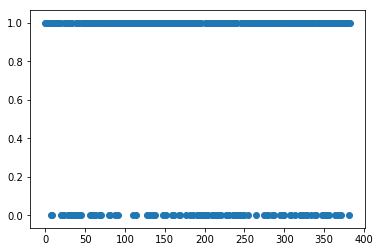

In [31]:
_ = plt.scatter(np.arange(0,len(right_pred)),right_pred[:,0])

In [17]:
right_pred[:split]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [35]:
np.array(new_right_labels).shape

(383, 2)

In [38]:
metrics.accuracy_score(np.array(new_right_labels)[:,0],right_pred[:,0]>0.9)

0.7232375979112271

In [30]:
right_pred[:,0]

array([1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00,
       0.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00,
       0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       0.0000000e+00, 1.0000000e+00, 1.0000000e+00, 0.0000000e

/Users/cgroschner/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


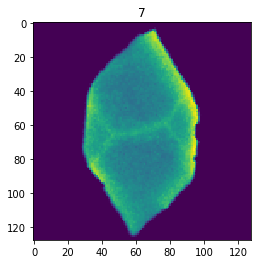

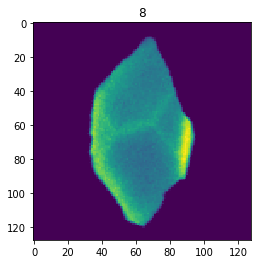

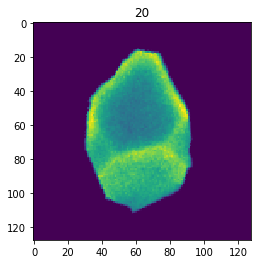

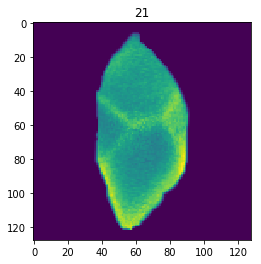

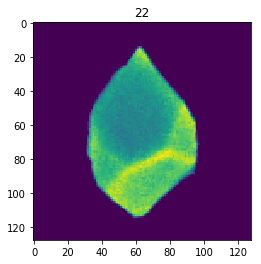

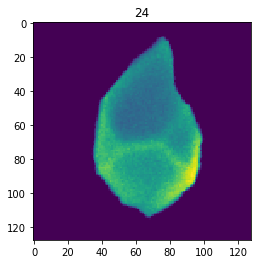

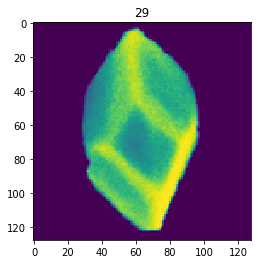

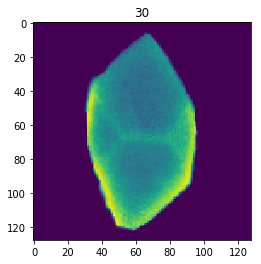

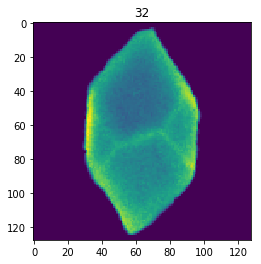

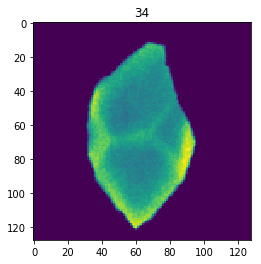

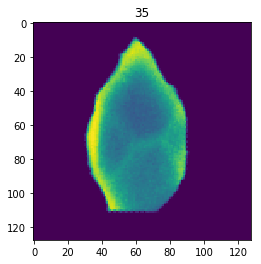

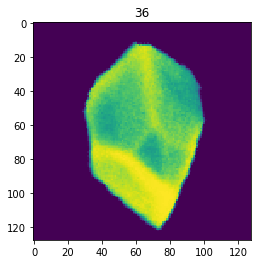

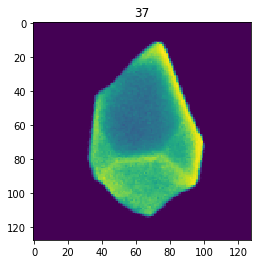

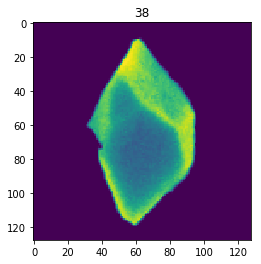

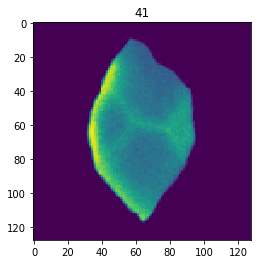

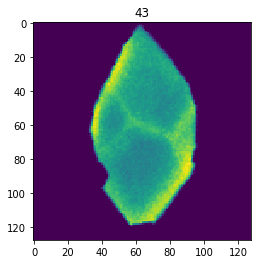

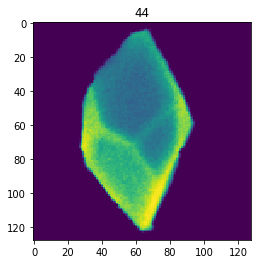

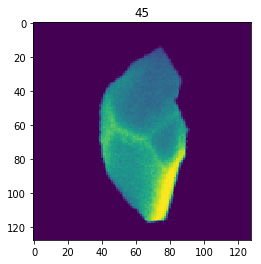

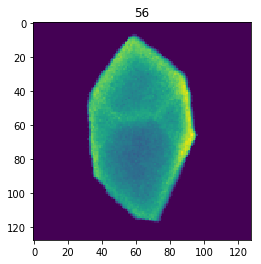

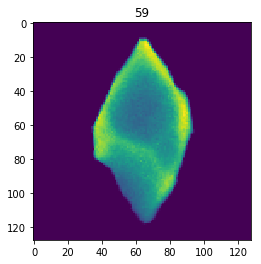

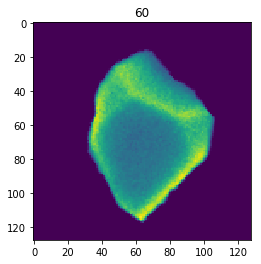

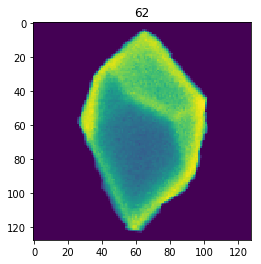

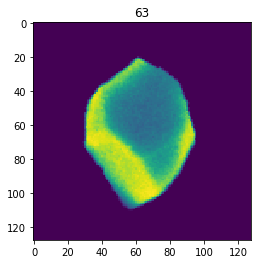

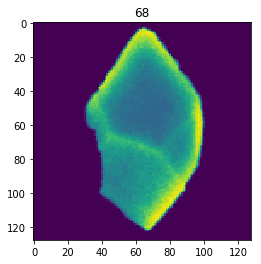

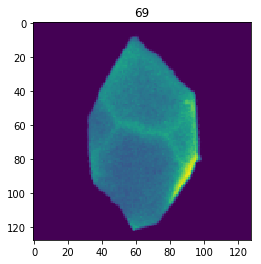

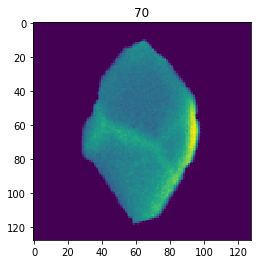

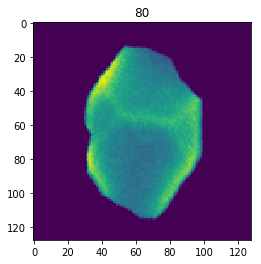

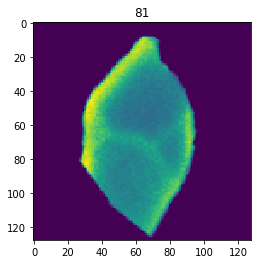

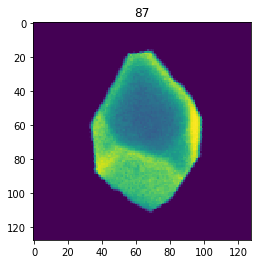

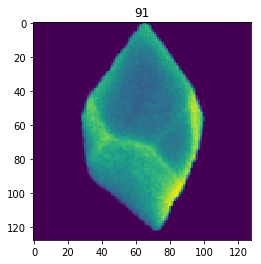

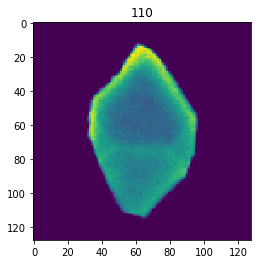

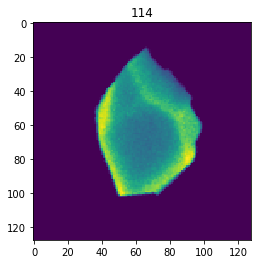

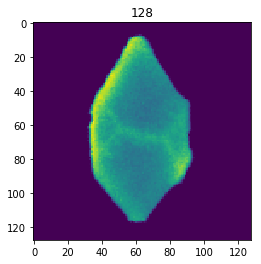

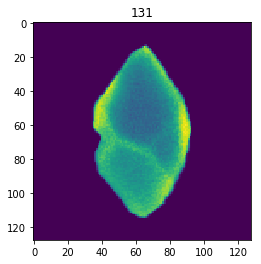

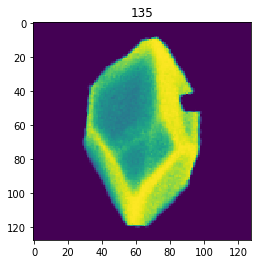

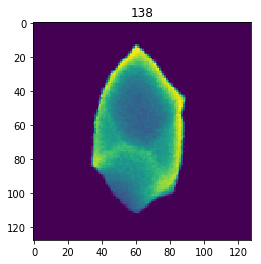

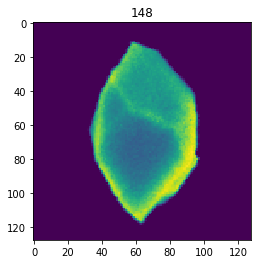

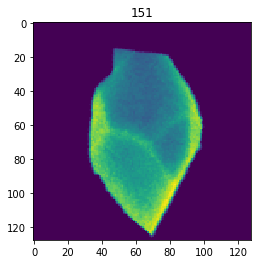

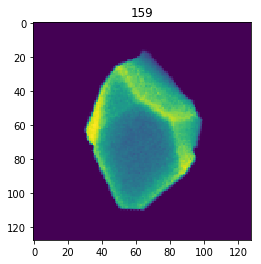

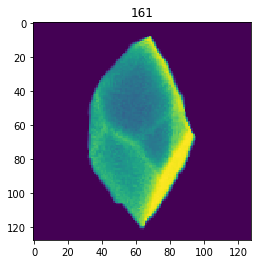

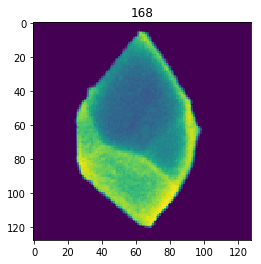

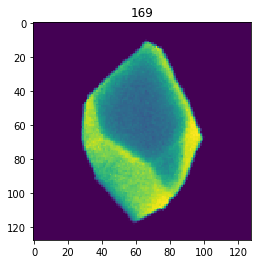

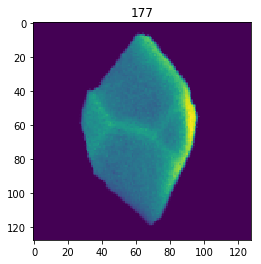

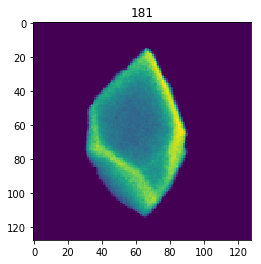

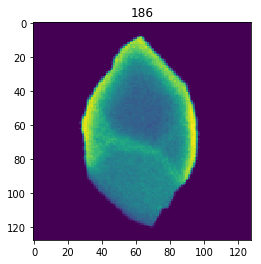

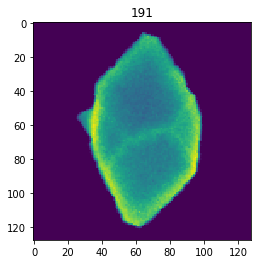

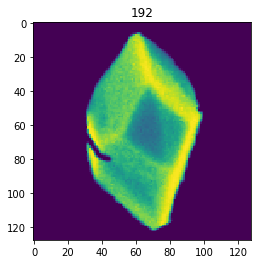

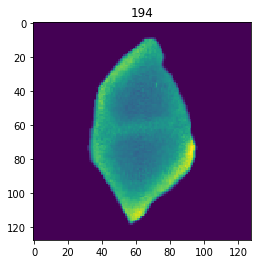

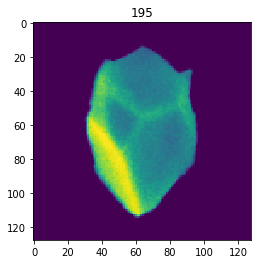

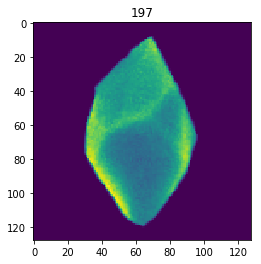

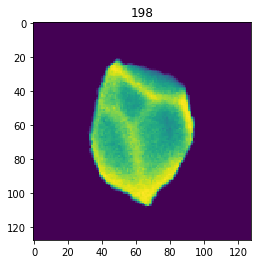

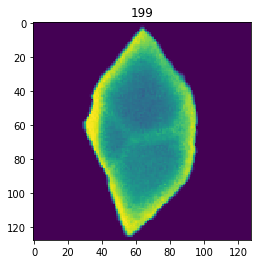

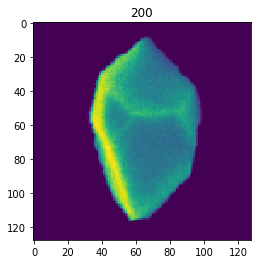

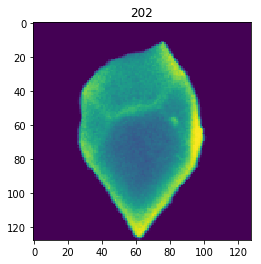

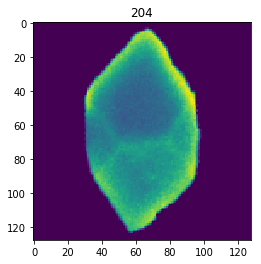

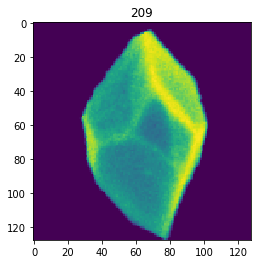

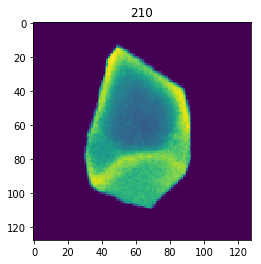

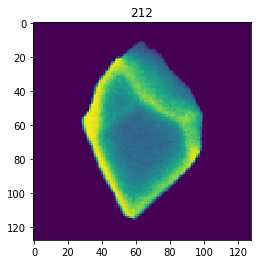

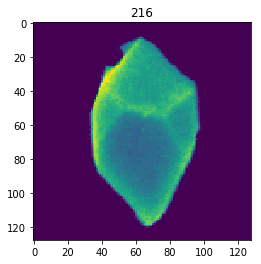

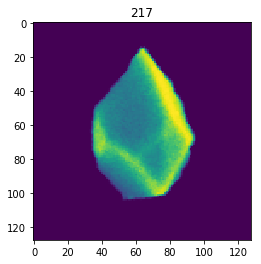

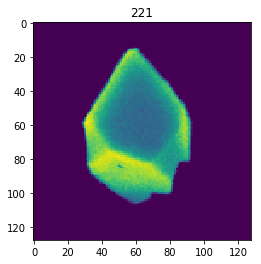

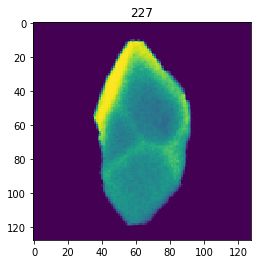

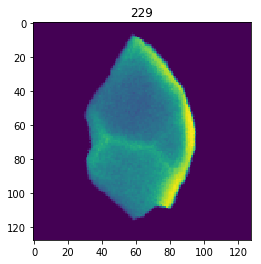

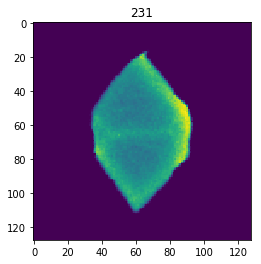

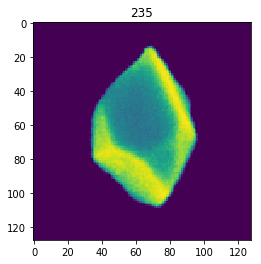

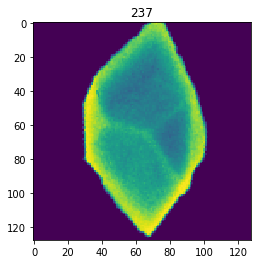

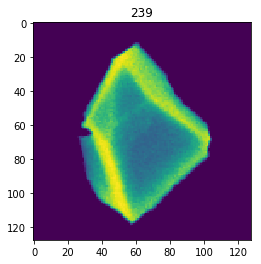

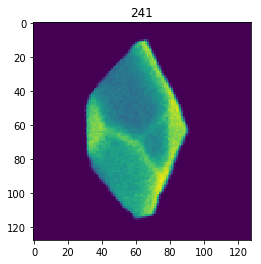

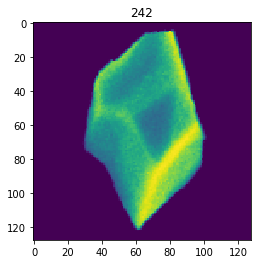

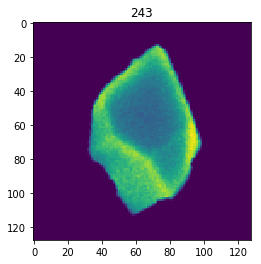

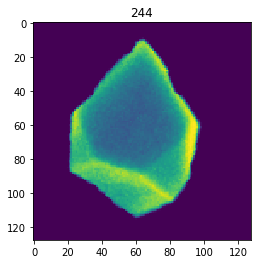

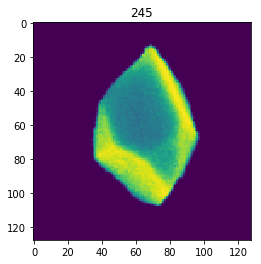

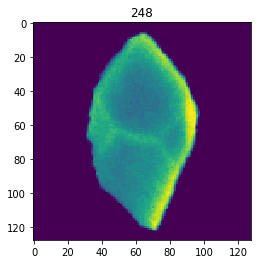

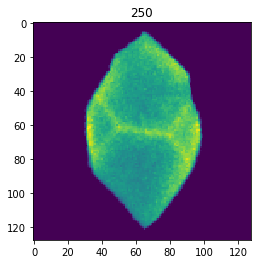

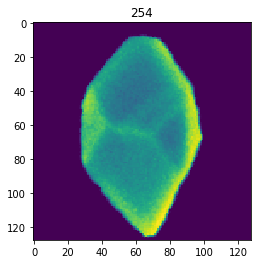

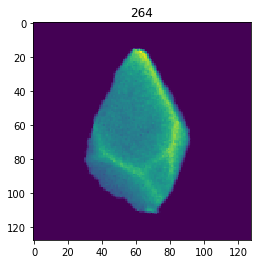

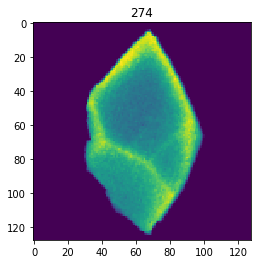

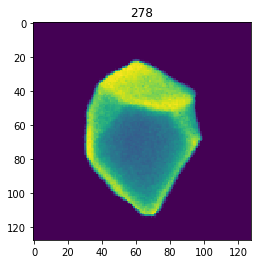

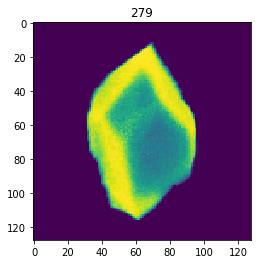

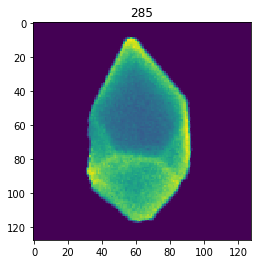

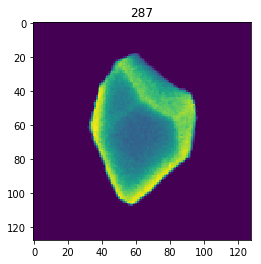

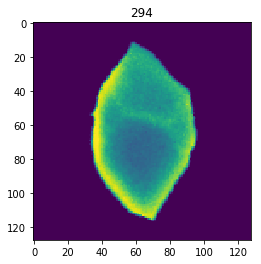

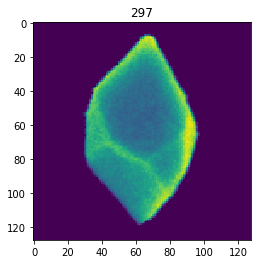

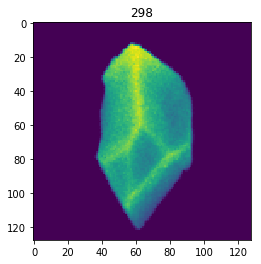

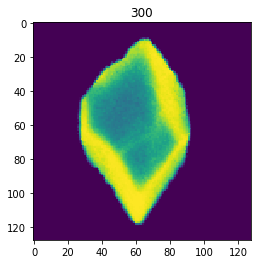

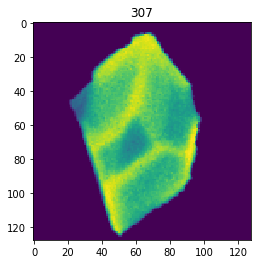

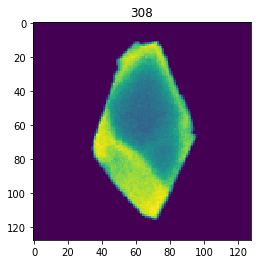

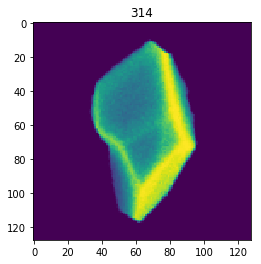

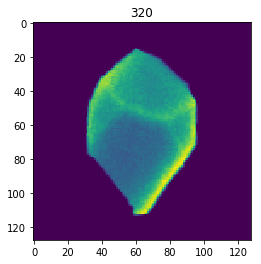

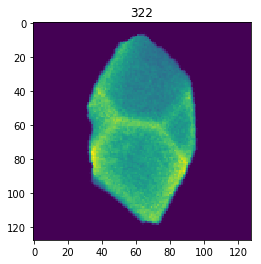

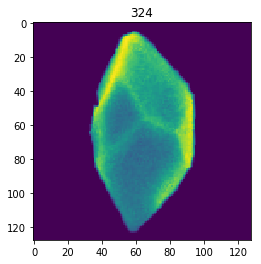

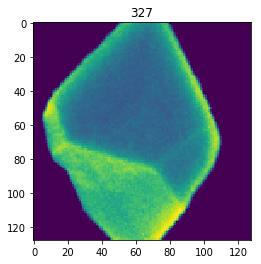

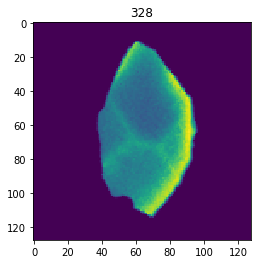

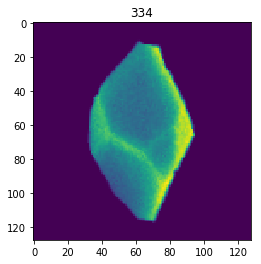

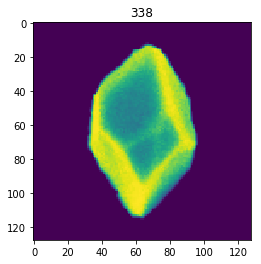

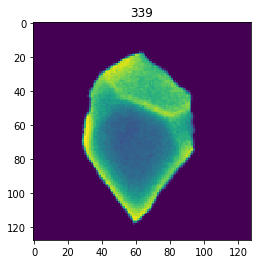

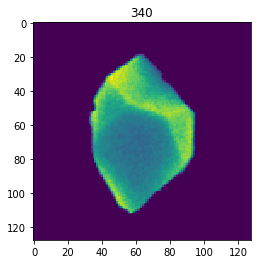

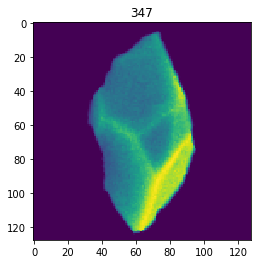

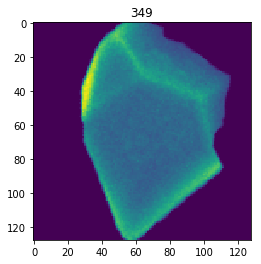

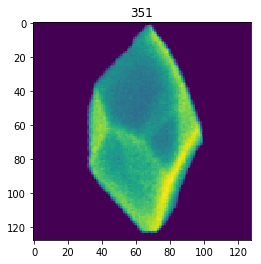

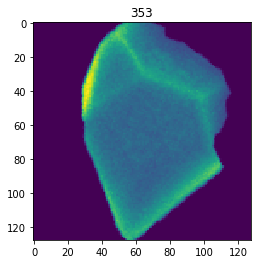

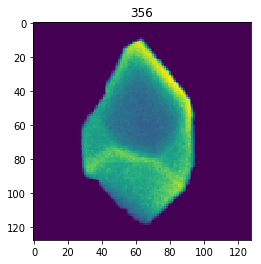

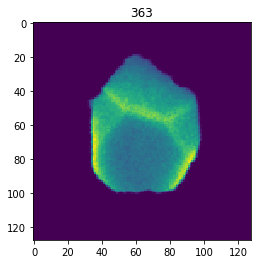

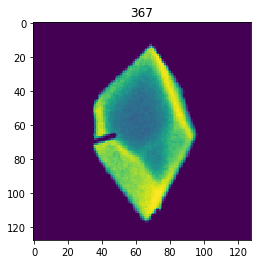

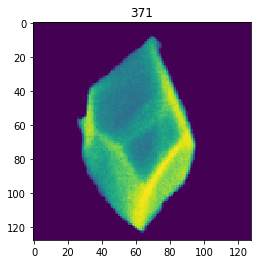

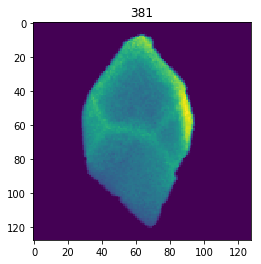

In [41]:
for idx,label in enumerate(right_pred[:,0]):
    if label < 1:
        plt.figure()
        plt.imshow(new_right_images[idx])
        plt.title(idx)

In [46]:
def down(filters, input_):
    down_ = Conv2D(filters, (3, 3))(input_)
    down_res = Activation('relu')(down_)
    down_pool = MaxPooling2D((2, 2))(down_)
    return down_pool

def final_stack(input1_):
    flat = Flatten()(input1_)
    dense1 = Dense(64*2)(flat)
    act1 = Activation('relu')(dense1)
    drop = Dropout(0.5)(act1)
    dense2 = Dense(2)(drop)
    act2 = Activation('softmax')(dense2)
    return act2


def first_cnn(input_):
    down1 = down(32*2,input_)
    down2 = down(32*2,down1)
    down3 = down(64*2,down2)
    down4 = down(64*2,down3)
    down5 = down(64*2,down4)
    # final = first_final_stack(down5)
    return down5

def complete_model(input_shape):
    input1 = Input(shape=input_shape)
    final1 = first_cnn(input1)
    final = final_stack(final1)
    model = Model(inputs=input1, outputs=final)
    return model

model = complete_model((128, 128,1))

model.compile(loss='categorical_crossentropy',
              optimizer='Adadelta',
              metrics=['accuracy'])

In [47]:
model.load_weights('savio_nets/rcnnV1_counternet_10pwrongleftrightlabels_weights_20200821.h5')

In [52]:
right_images = np.load('right__Chiral_D_Large_TIFF_Cropped_four_rows_sel_NPs_rotated.npy')

In [53]:
right_pred = model.predict(np.expand_dims(right_images,axis=3))

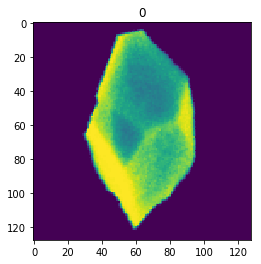

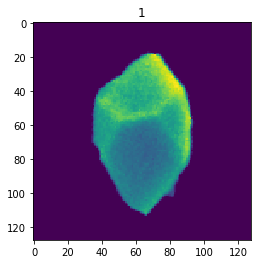

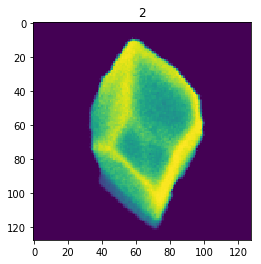

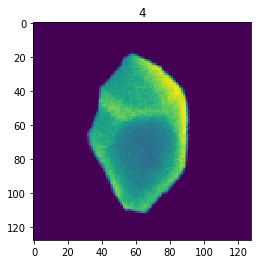

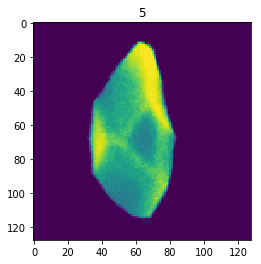

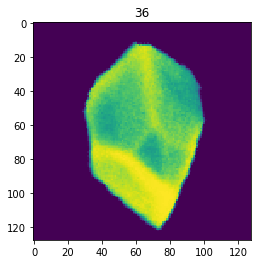

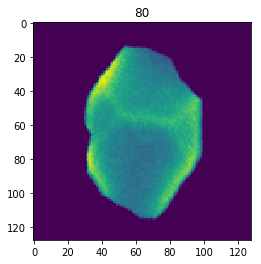

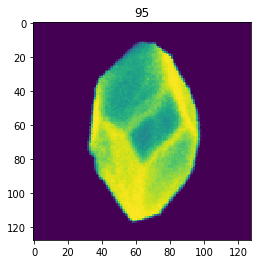

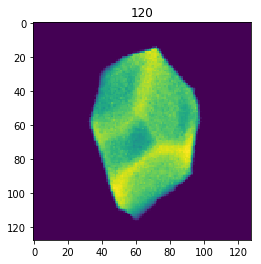

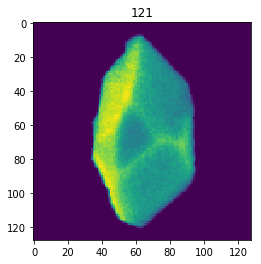

In [54]:
for idx,label in enumerate(right_pred[:,0]):
    if label < 1:
        plt.figure()
        plt.imshow(new_right_images[idx])
        plt.title(idx)

In [57]:
metrics.accuracy_score(np.array(right_labels)[:,0],right_pred[:,0]>0.9)

0.9358974358974359

In [56]:
right_labels = [[1,0] for i in np.arange(0,len(right_pred))]

In [93]:
del modelE

In [9]:
modelE = keras.models.Sequential()
modelE.add(Conv2D(32, (3, 3), input_shape=(128, 128,1)))
modelE.add(Activation('relu'))
modelE.add(MaxPooling2D(pool_size=(2, 2)))

modelE.add(Conv2D(32, (3, 3)))
modelE.add(Activation('relu'))
modelE.add(MaxPooling2D(pool_size=(2, 2)))

modelE.add(Conv2D(64, (3, 3)))
modelE.add(Activation('relu'))
modelE.add(MaxPooling2D(pool_size=(2, 2)))

modelE.add(Conv2D(64, (3, 3)))
modelE.add(Activation('relu'))
modelE.add(MaxPooling2D(pool_size=(2, 2)))

modelE.add(Conv2D(64, (3, 3)))
modelE.add(Activation('relu'))
modelE.add(MaxPooling2D(pool_size=(2, 2)))

modelE.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
modelE.add(Dense(64))
modelE.add(Activation('relu'))
modelE.add(Dropout(0.5))
modelE.add(Dense(2))
modelE.add(Activation('softmax'))

modelE.compile(loss='categorical_crossentropy',
              optimizer='Adadelta',
              metrics=['accuracy'])


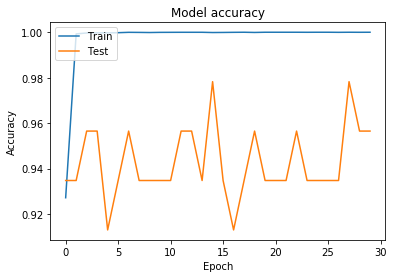

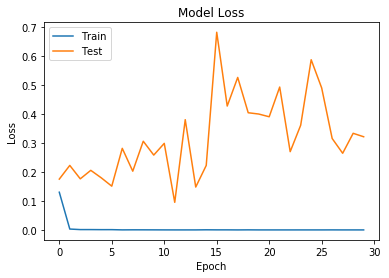

In [72]:
history = h5py.File('savio_nets/chirality_classification_00pwrongleftrightlabels_history_v4_20200912.h5','r')

list(history.keys())

plt.plot(history['acc'][:])
plt.plot(history['val_acc'][:])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

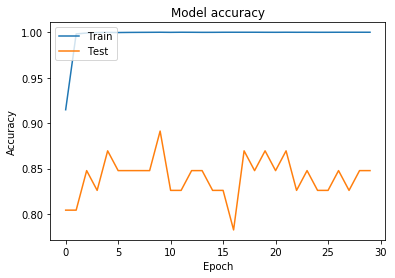

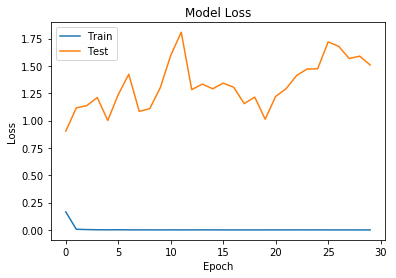

In [73]:
history = h5py.File('savio_nets/chirality_classification_05pwrongleftrightlabels_history_v4_20200912.h5','r')

list(history.keys())

plt.plot(history['acc'][:])
plt.plot(history['val_acc'][:])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

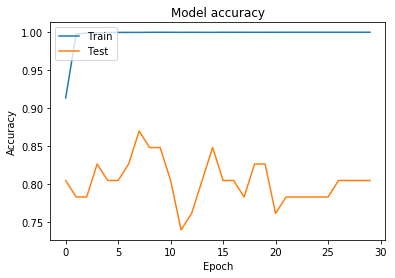

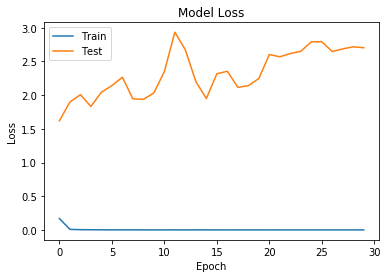

In [74]:
history = h5py.File('savio_nets/chirality_classification_10pwrongleftrightlabels_history_v4_20200912.h5','r')

list(history.keys())

plt.plot(history['acc'][:])
plt.plot(history['val_acc'][:])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

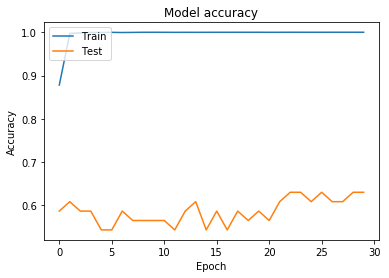

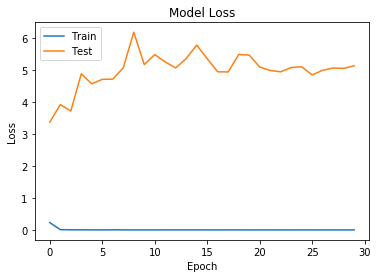

In [75]:
history = h5py.File('savio_nets/chirality_classification_20pwrongleftrightlabels_history_v4_20200912.h5','r')

list(history.keys())

plt.plot(history['acc'][:])
plt.plot(history['val_acc'][:])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

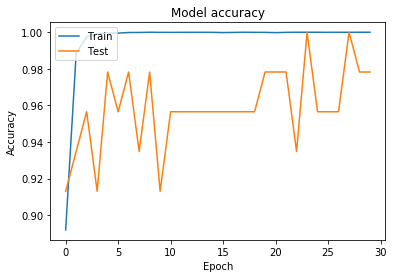

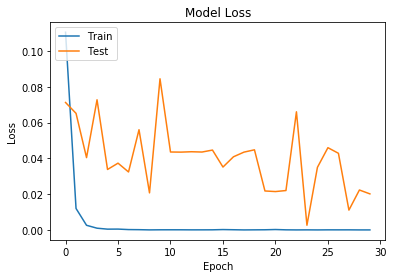

In [151]:
history = h5py.File('savio_nets/chirality_classification_00pwrongleftrightlabels_history_v5_20200913.h5','r')

list(history.keys())

plt.plot(history['acc'][:])
plt.plot(history['val_acc'][:])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

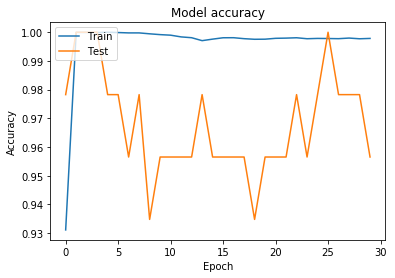

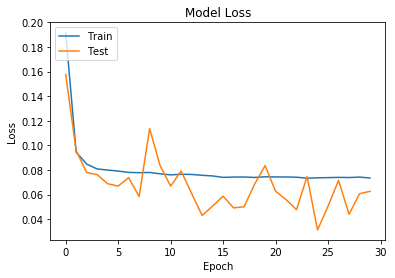

In [7]:
history = h5py.File('savio_nets/chirality_classification_00pwrongleftrightlabels_history_v6_20200914.h5','r')

list(history.keys())

plt.plot(history['acc'][:])
plt.plot(history['val_acc'][:])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

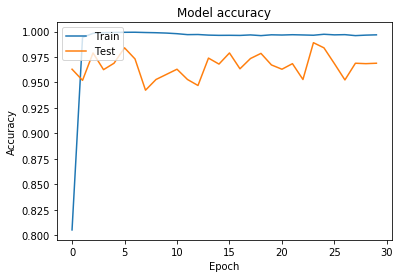

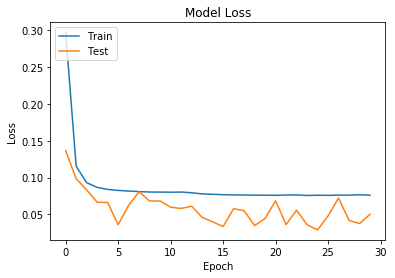

In [29]:
history = h5py.File('savio_nets/chirality_classification_00pwrongleftrightlabels_history_v7_20200914.h5','r')

list(history.keys())

plt.plot(history['acc'][:])
plt.plot(history['val_acc'][:])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


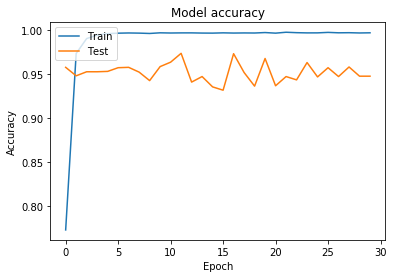

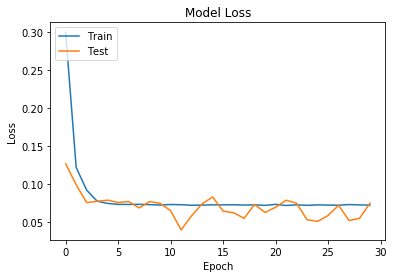

In [50]:
history = h5py.File('savio_nets/chirality_classification_00pwrongleftrightlabels_history_v8_20200914.h5','r')

list(history.keys())

plt.plot(history['acc'][:])
plt.plot(history['val_acc'][:])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

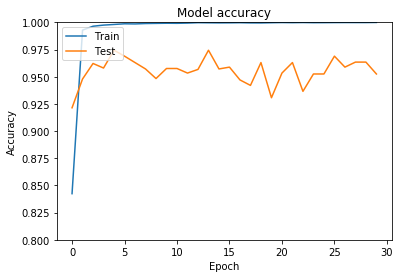

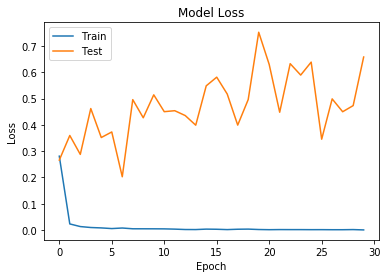

In [70]:
history = h5py.File('savio_nets/rcnnV1_counternet_00pwrongleftrightlabels_history_20200901.h5','r')

list(history.keys())

plt.plot(history['acc'][:])
plt.plot(history['val_acc'][:])
plt.ylim([0.8,1])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

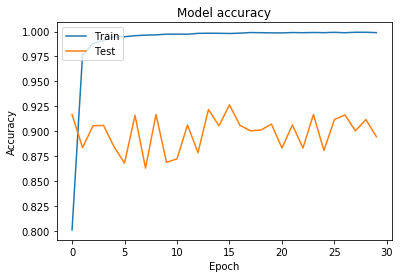

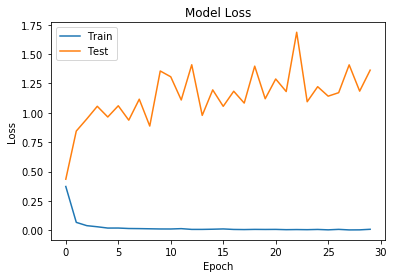

In [59]:
history = h5py.File('savio_nets/rcnnV1_counternet_05pwrongleftrightlabels_history_20200821.h5','r')

list(history.keys())

plt.plot(history['acc'][:])
plt.plot(history['val_acc'][:])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

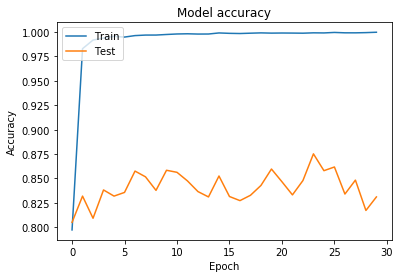

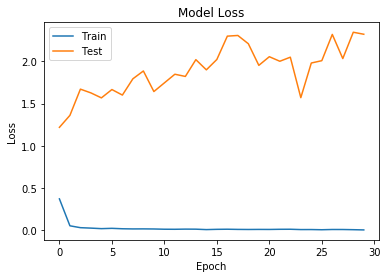

In [60]:
history = h5py.File('savio_nets/rcnnV1_counternet_10pwrongleftrightlabels_history_20200821.h5','r')

list(history.keys())

plt.plot(history['acc'][:])
plt.plot(history['val_acc'][:])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

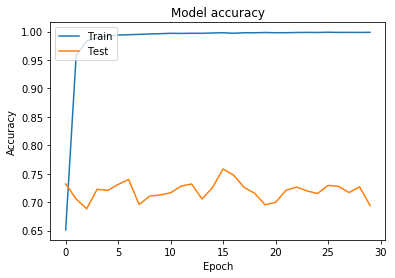

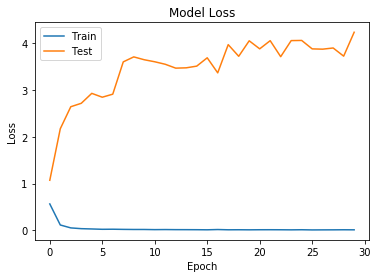

In [61]:
history = h5py.File('savio_nets/rcnnV1_counternet_20pwrongleftrightlabels_history_20200821.h5','r')

list(history.keys())

plt.plot(history['acc'][:])
plt.plot(history['val_acc'][:])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

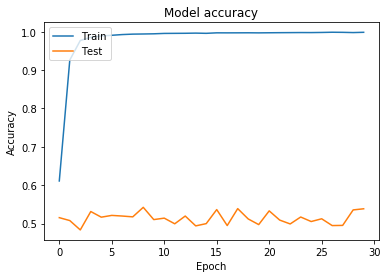

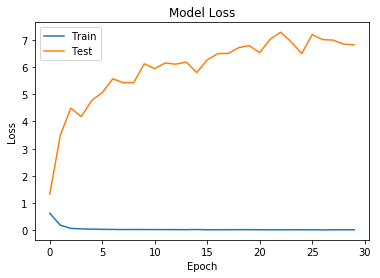

In [63]:
history = h5py.File('savio_nets/rcnnV1_counternet_40pwrongleftrightlabels_history_20200821.h5','r')

list(history.keys())

plt.plot(history['acc'][:])
plt.plot(history['val_acc'][:])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

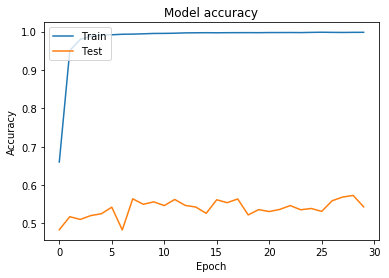

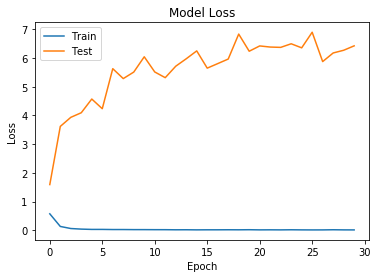

In [64]:
history = h5py.File('savio_nets/rcnnV1_counternet_50pwrongleftrightlabels_history_20200821.h5','r')

list(history.keys())

plt.plot(history['acc'][:])
plt.plot(history['val_acc'][:])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [51]:
del modelE

In [52]:
modelE = keras.models.Sequential()
modelE.add(Conv2D(32, (3, 3), input_shape=(128, 128,1)))
modelE.add(Activation('relu'))
modelE.add(MaxPooling2D(pool_size=(2, 2)))

modelE.add(Conv2D(32, (3, 3)))
modelE.add(Activation('relu'))
modelE.add(MaxPooling2D(pool_size=(2, 2)))

modelE.add(Conv2D(64, (3, 3)))
modelE.add(Activation('relu'))
modelE.add(MaxPooling2D(pool_size=(2, 2)))

modelE.add(Conv2D(64, (3, 3)))
modelE.add(Activation('relu'))
modelE.add(MaxPooling2D(pool_size=(2, 2)))

modelE.add(Conv2D(64, (3, 3)))
modelE.add(Activation('relu'))
modelE.add(MaxPooling2D(pool_size=(2, 2)))

modelE.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
modelE.add(Dense(64))
modelE.add(Activation('relu'))
modelE.add(Dropout(0.5))
modelE.add(Dense(1))
modelE.add(Activation('linear'))

modelE.compile(loss='mean_absolute_error',
              optimizer='Adadelta',
              metrics=['accuracy'])

In [38]:
modelE.load_weights('savio_nets/chirality_classification_00pwrongleftrightlabels_weights_v7_20200914.h5')

In [39]:
valX = np.expand_dims(h5py.File('20200912_20perror_Chiral_D_Large_TIFF_Cropped_four_rows_sel_NPs_rotated.h5','r')['valX'][:,:,:],axis=3)

In [40]:
valY = h5py.File('20200912_20perror_Chiral_D_Large_TIFF_Cropped_four_rows_sel_NPs_rotated.h5','r')['valY'][:]

In [53]:
pred0perror = modelE.predict(X_val_shuff)

In [54]:
pred0perror

array([[-1.56924091e-02],
       [-1.22235743e-02],
       [-1.73265617e-02],
       [-8.50894116e-03],
       [ 1.57384516e-03],
       [-1.24327904e-02],
       [-1.59928072e-02],
       [-1.44120343e-02],
       [-5.21653704e-03],
       [-8.07092898e-03],
       [-2.61998437e-02],
       [-6.30126242e-03],
       [-1.39847444e-02],
       [-8.14030506e-03],
       [-1.37515739e-02],
       [-1.82235874e-02],
       [-1.61625873e-02],
       [-9.16043483e-03],
       [-2.91254465e-02],
       [-1.83505975e-02],
       [-1.60658825e-02],
       [-3.81723349e-03],
       [-2.43785698e-02],
       [-1.05209379e-02],
       [ 1.43163046e-03],
       [-1.31912939e-02],
       [-1.37547152e-02],
       [-2.80007981e-02],
       [-3.66529748e-02],
       [-1.83794983e-02],
       [-2.03662440e-02],
       [-7.28957541e-03],
       [-1.52763613e-02],
       [-2.57578362e-02],
       [-1.74851809e-02],
       [-2.27976404e-02],
       [-2.07117684e-02],
       [-2.90584099e-03],
       [-1.5

In [55]:
tf.keras.metrics.Accuracy(Y_val_shuff[:][0],pred0perror)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [44]:
u = []
for i in pred0perror:
    if i[0] > i[1]:
        u.append([1,0])
    elif i[1] >= i[0]:
        u.append([0,1])
u = np.array(u)

In [46]:
u

array([[1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0]])

In [45]:
metrics.accuracy_score(valY,u)

0.6136363636363636

In [68]:
valY

array([[1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1]])

In [69]:
valY.shape

(44, 2)

In [71]:
valX.shape

(44, 128, 128, 1)